In [1]:
import pickle

In [2]:
import os
import pandas as pd

In [3]:
with open('/Users/naokihiratani/Documents/HMM_RIS_2/AI_HMM_analysis_data_ephys.pkl', 'rb') as f:
    combined_data_AI = pickle.load(f)

In [4]:
AI_ad = combined_data_AI['additional_data']

In [5]:
from matplotlib.colors import Normalize
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib import cm

In [13]:

from matplotlib.backends.backend_pdf import PdfPages


In [6]:

def assign_state_to_neurons_using_state_vector(state_representations, valid_cluster_ids):
    assigned_states = {}
    for neuron_idx, cluster_id in enumerate(valid_cluster_ids):

        state_vector = state_representations[:, neuron_idx]
        assigned_state = np.argmax(state_vector)
        assigned_states[cluster_id] = assigned_state
    #num_states = state_representations.shape[0]
    #print(f"Total number of states: {num_states}")

    return assigned_states

def sort_neurons_by_assigned_state(assigned_states, spike_times_window):
    """
    Sort neurons by assigned state.
    Neurons with the same preferred state are sorted together.
    """
    # Sort neurons by assigned state
    sorted_neurons = sorted(assigned_states.items(), key=lambda x: x[1])

    sorted_spike_times_window = {
        cluster_id: spike_times_window[cluster_id] for cluster_id, _ in sorted_neurons
    }
    
    return sorted_spike_times_window
def plot_sorted_raster_with_states(session_id, region, data):
    # Extract the relevant data
    bins_window = data['bins_window']
    most_likely_states_window = data['most_likely_states_window']
    spike_times_window = data['spike_times_window']
    state_representations = data['state_representations']
    valid_cluster_ids = data['valid_cluster_ids']
    time_window_start, time_window_end = data['time_window']
    
    assigned_states = assign_state_to_neurons_using_state_vector(state_representations, valid_cluster_ids)
    
    sorted_spike_times_window = sort_neurons_by_assigned_state(
        assigned_states, spike_times_window)

    fig, ax = plt.subplots(figsize=(15, 10))

    unique_states = np.unique(most_likely_states_window)
    num_bins = len(bins_window) - 1
    
    for i in range(num_bins):
        state = most_likely_states_window[i]
        color = plt.cm.tab20(state % 20)  
        ax.add_patch(patches.Rectangle(
            (bins_window[i], 0),      
            bins_window[i+1] - bins_window[i], 
            len(sorted_spike_times_window)+ 1,  
            color=color,
            alpha=0.6 # Transparency
        ))

    # 
    for neuron_idx, (cluster_id, spike_times) in enumerate(sorted_spike_times_window.items()):
        if len(spike_times) > 0:
            ax.vlines(spike_times, neuron_idx + 0.5, neuron_idx + 1.5, color='black')
            
    num_states = state_representations.shape[0]
    

    ax.set_xlim(time_window_start, time_window_end)
    ax.set_ylim(0, len(sorted_spike_times_window)+1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Neurons (Sorted by Preferred State)')
    ax.set_title(f'Session: {session_id} | Region: {region}',fontsize=16)
    ax.text(0.5, 1.05, f"Total Number of States During SP: {num_states}", 
        transform=ax.transAxes, fontsize=16, ha='center', va='bottom')

    state_colors = {state: plt.cm.tab20(state % 20) for state in unique_states}
    legend_patches = [mpatches.Patch(color=color, label=f'State {state}') for state, color in state_colors.items()]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    

    plt.tight_layout()
    save_dir = "/Users/naokihiratani/Documents/HMM_RIS_2"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"raster_stateplot_{session_id}_{region}.pdf")
    plt.savefig(save_path, format='pdf')
    #

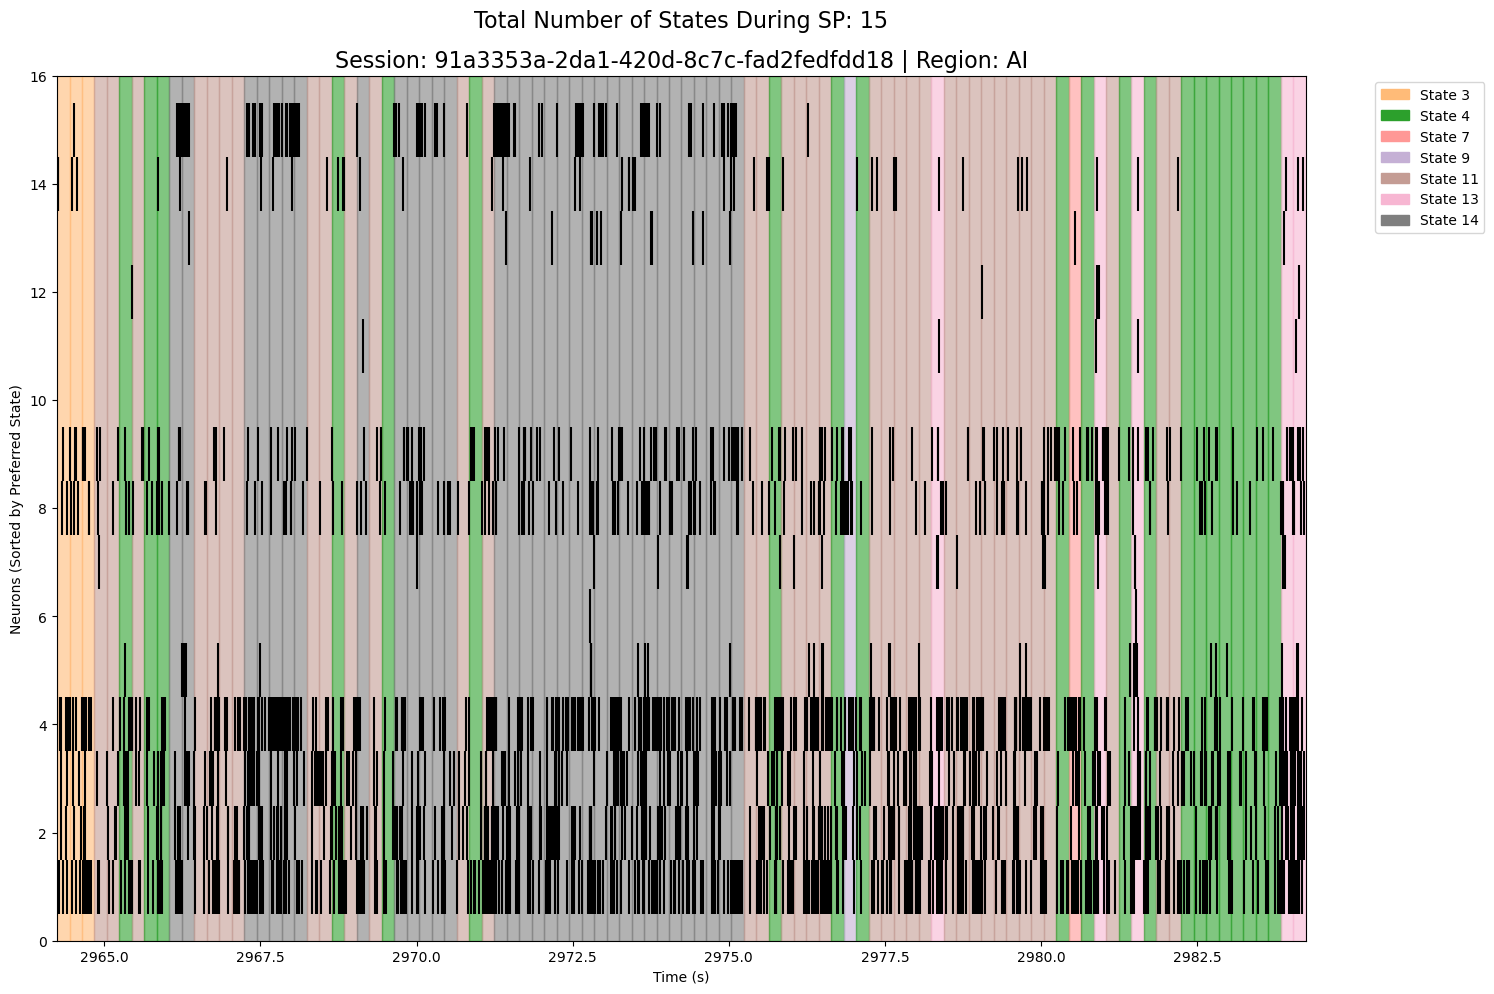

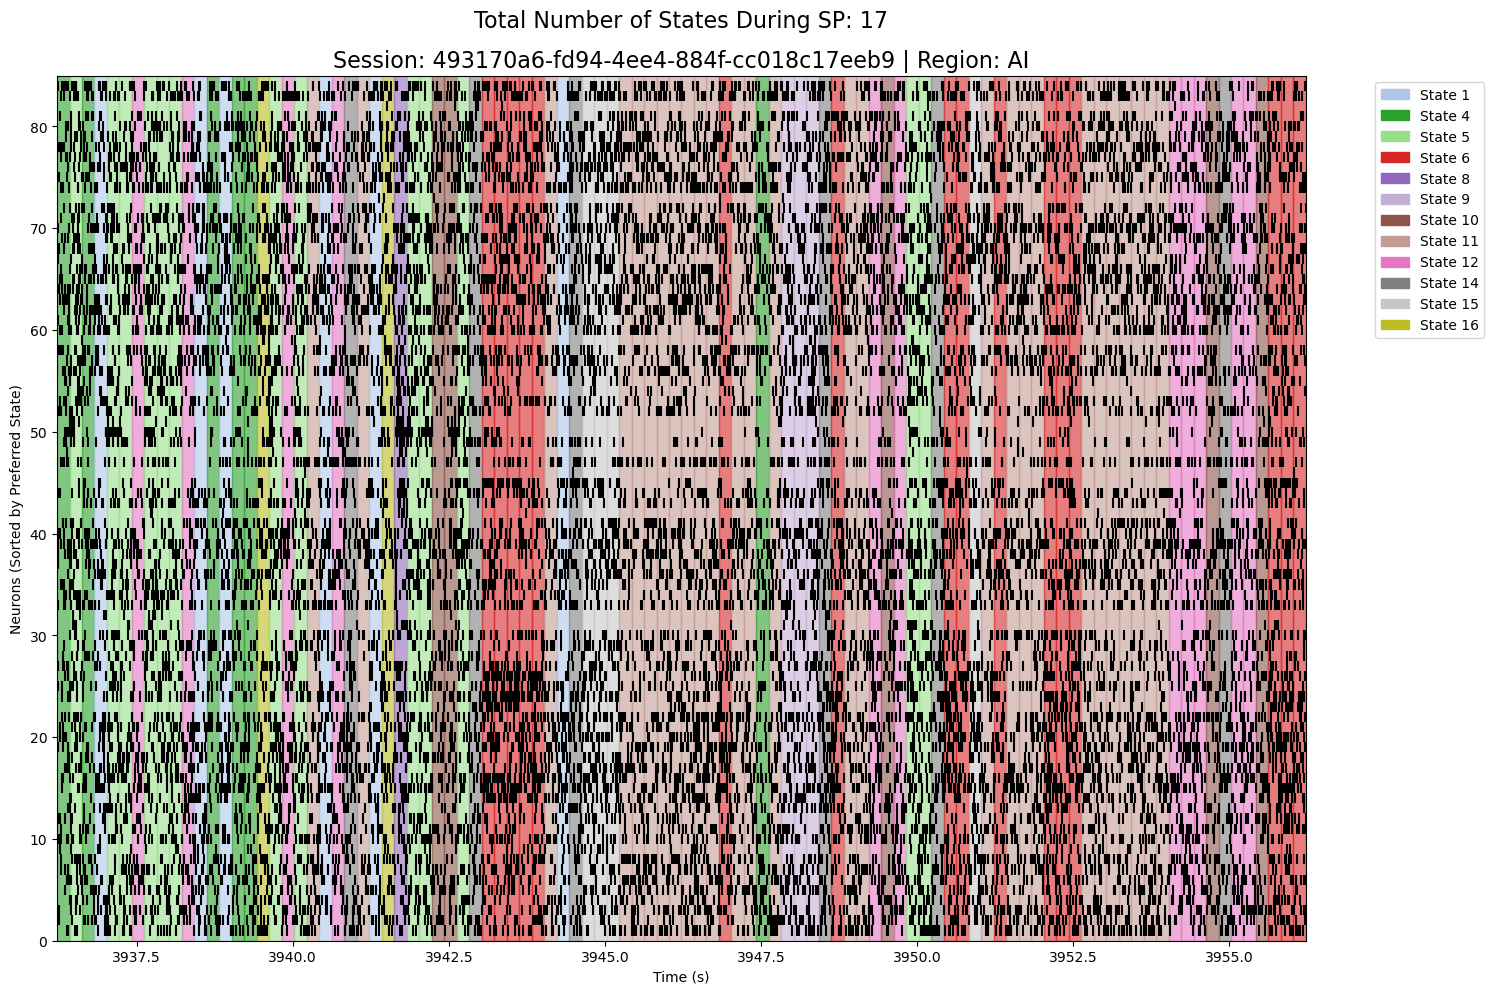

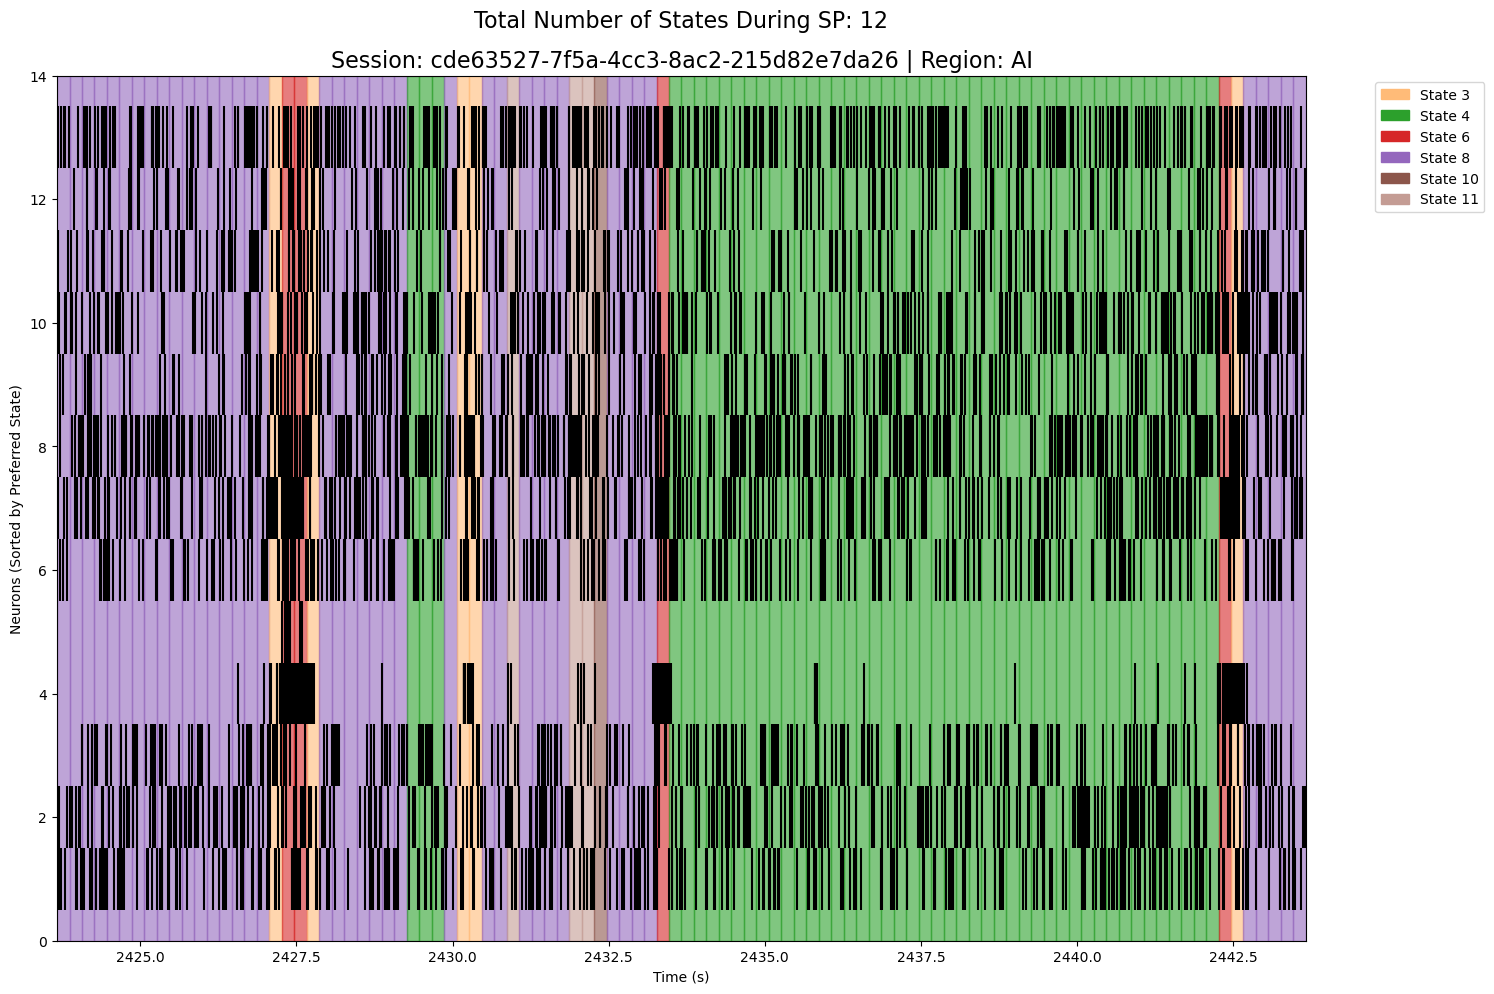

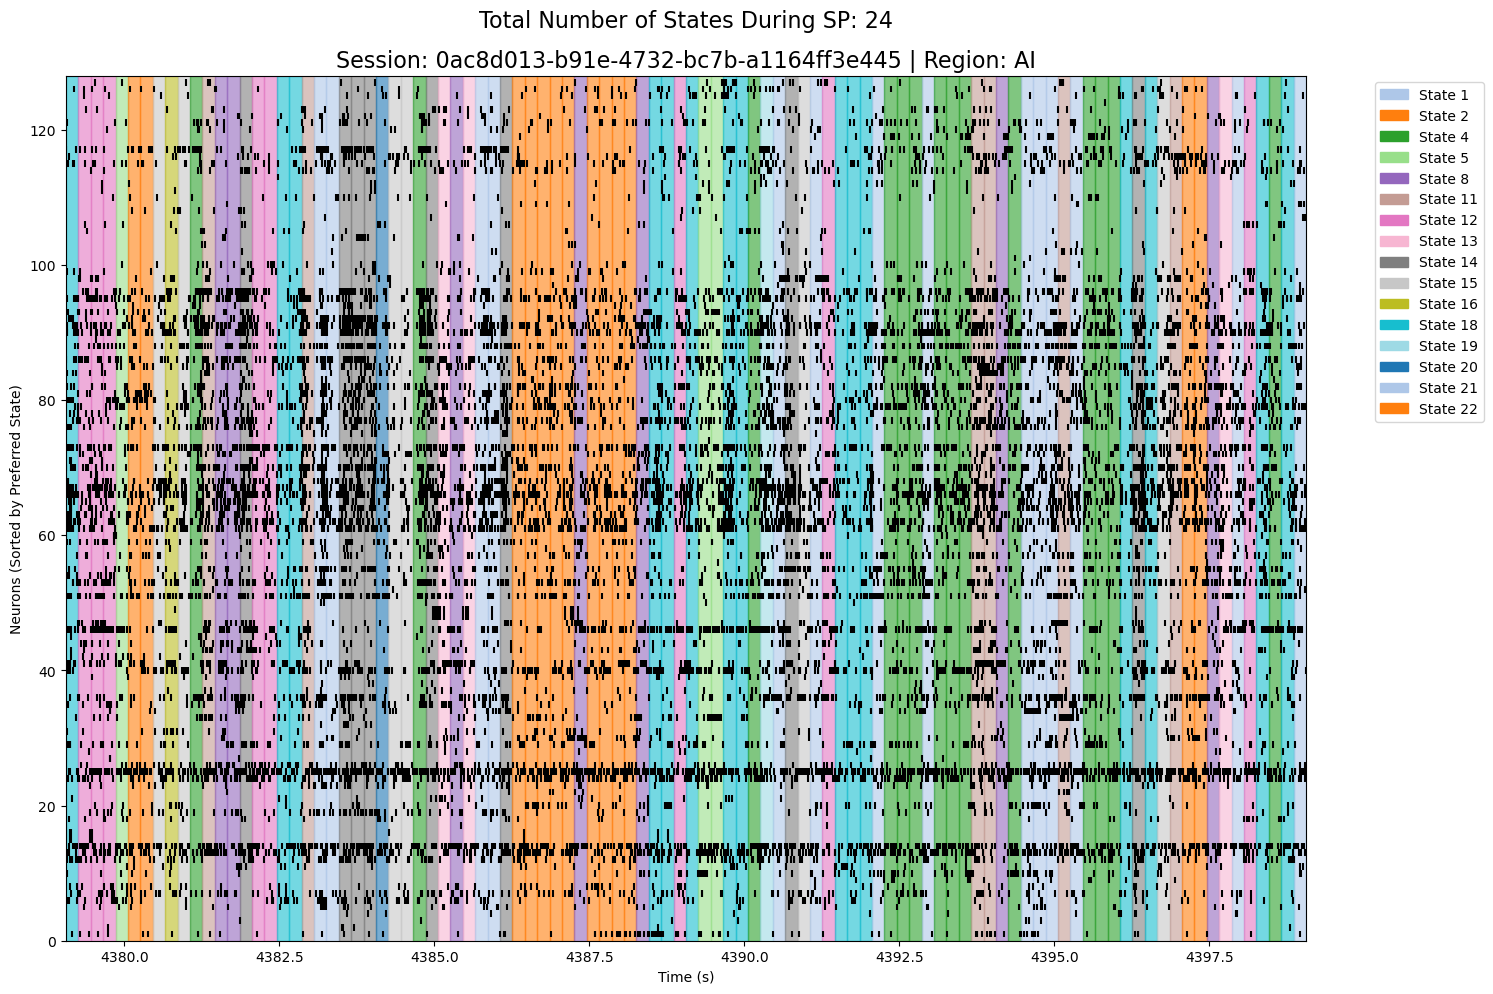

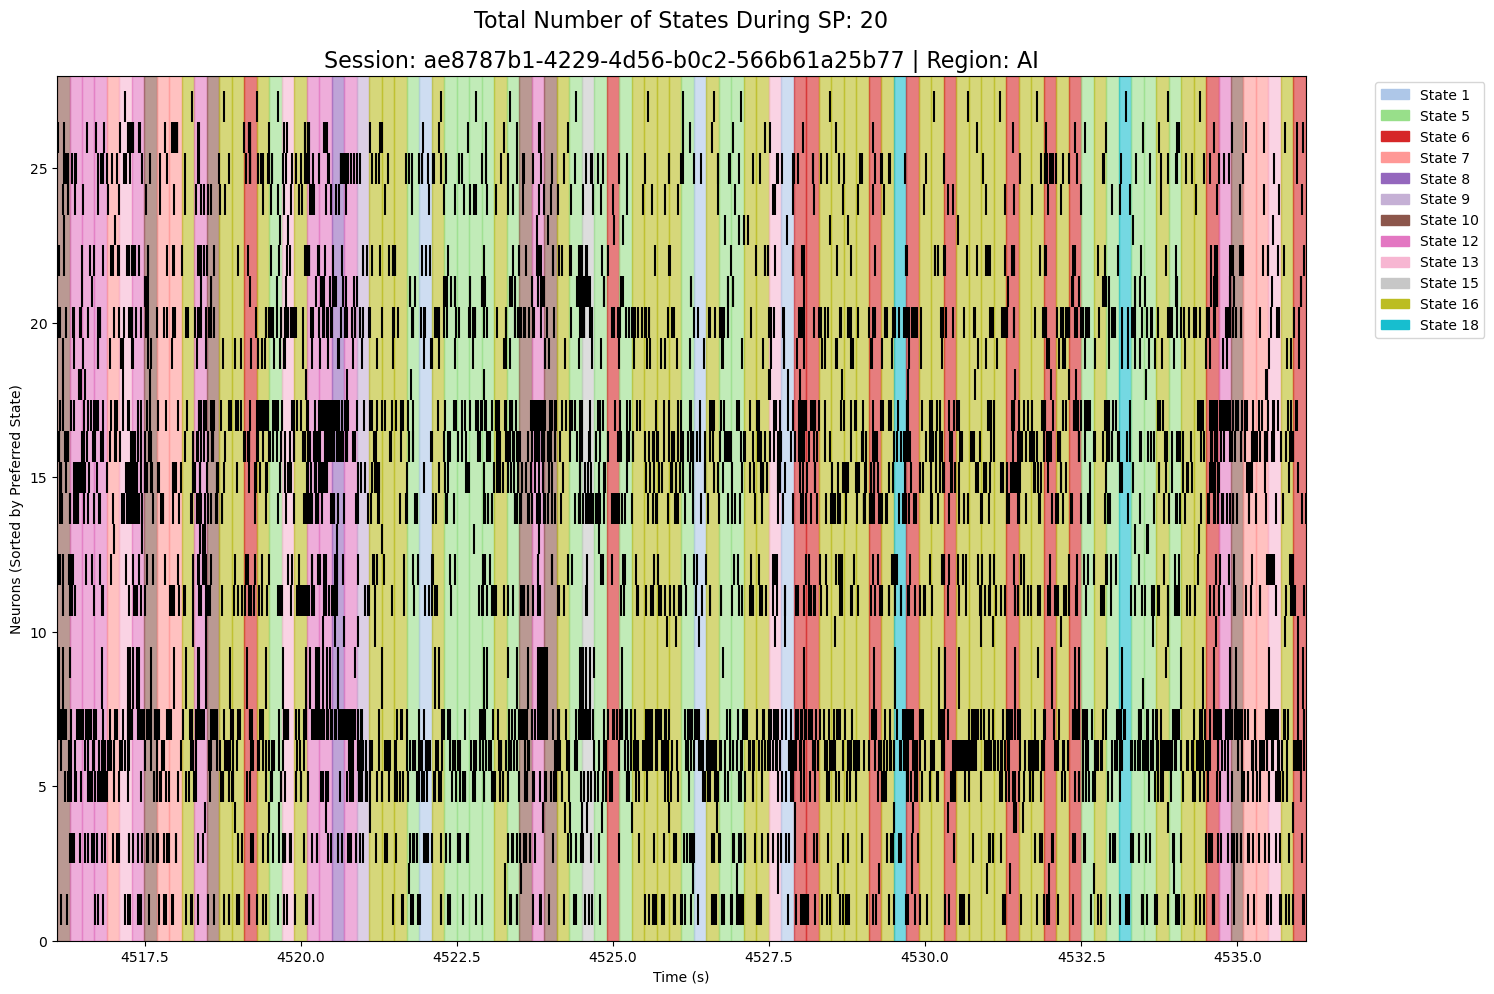

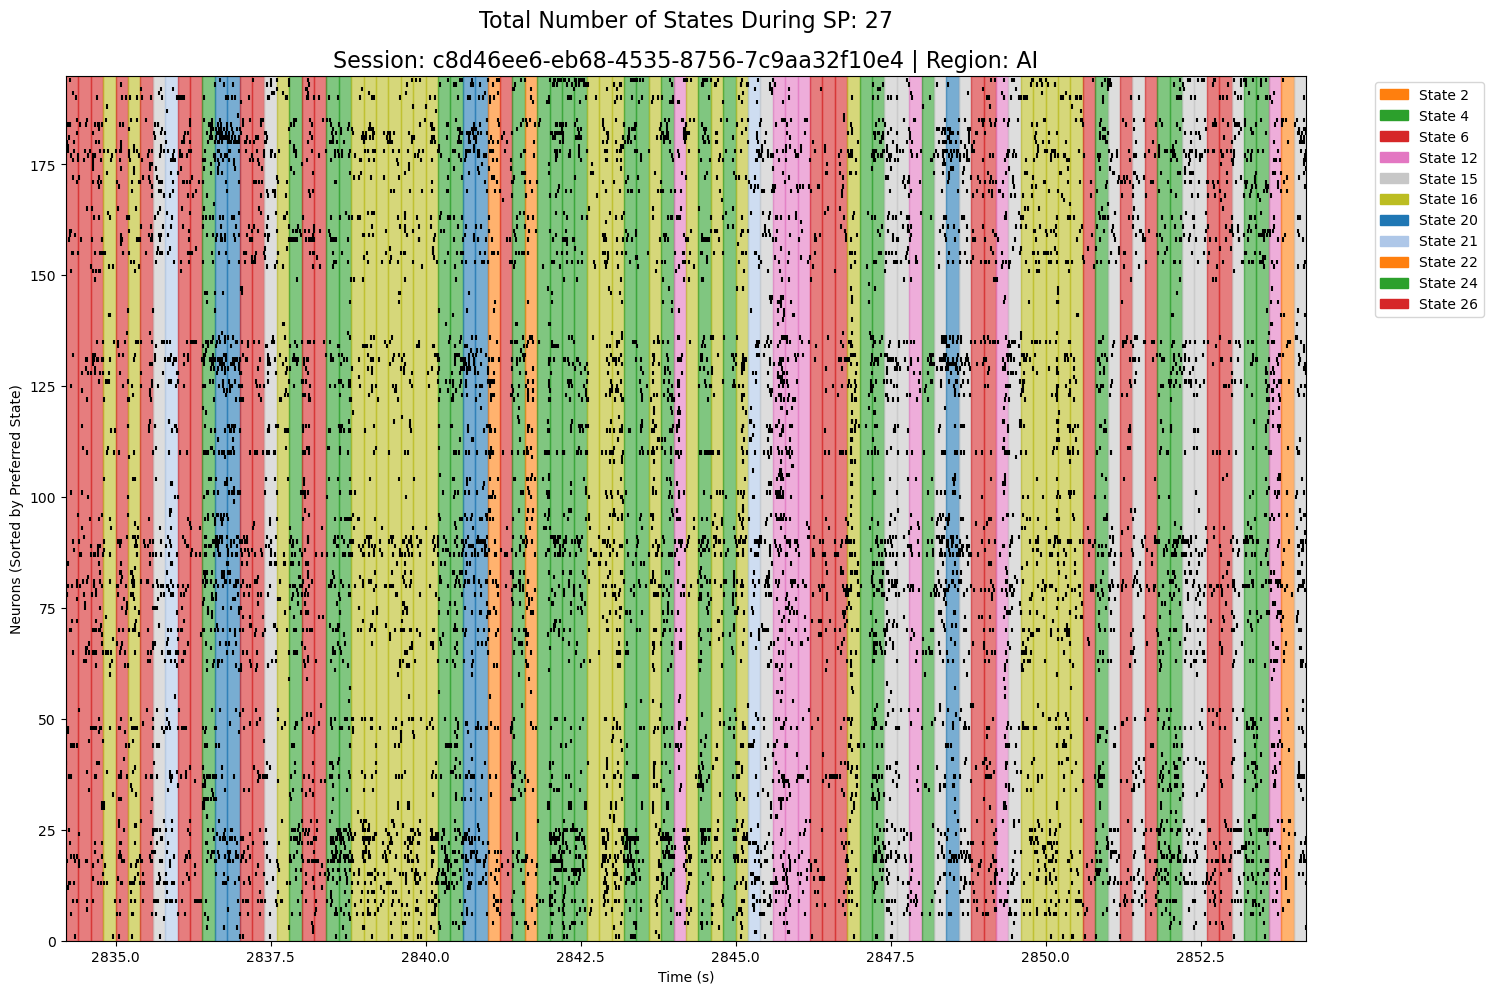

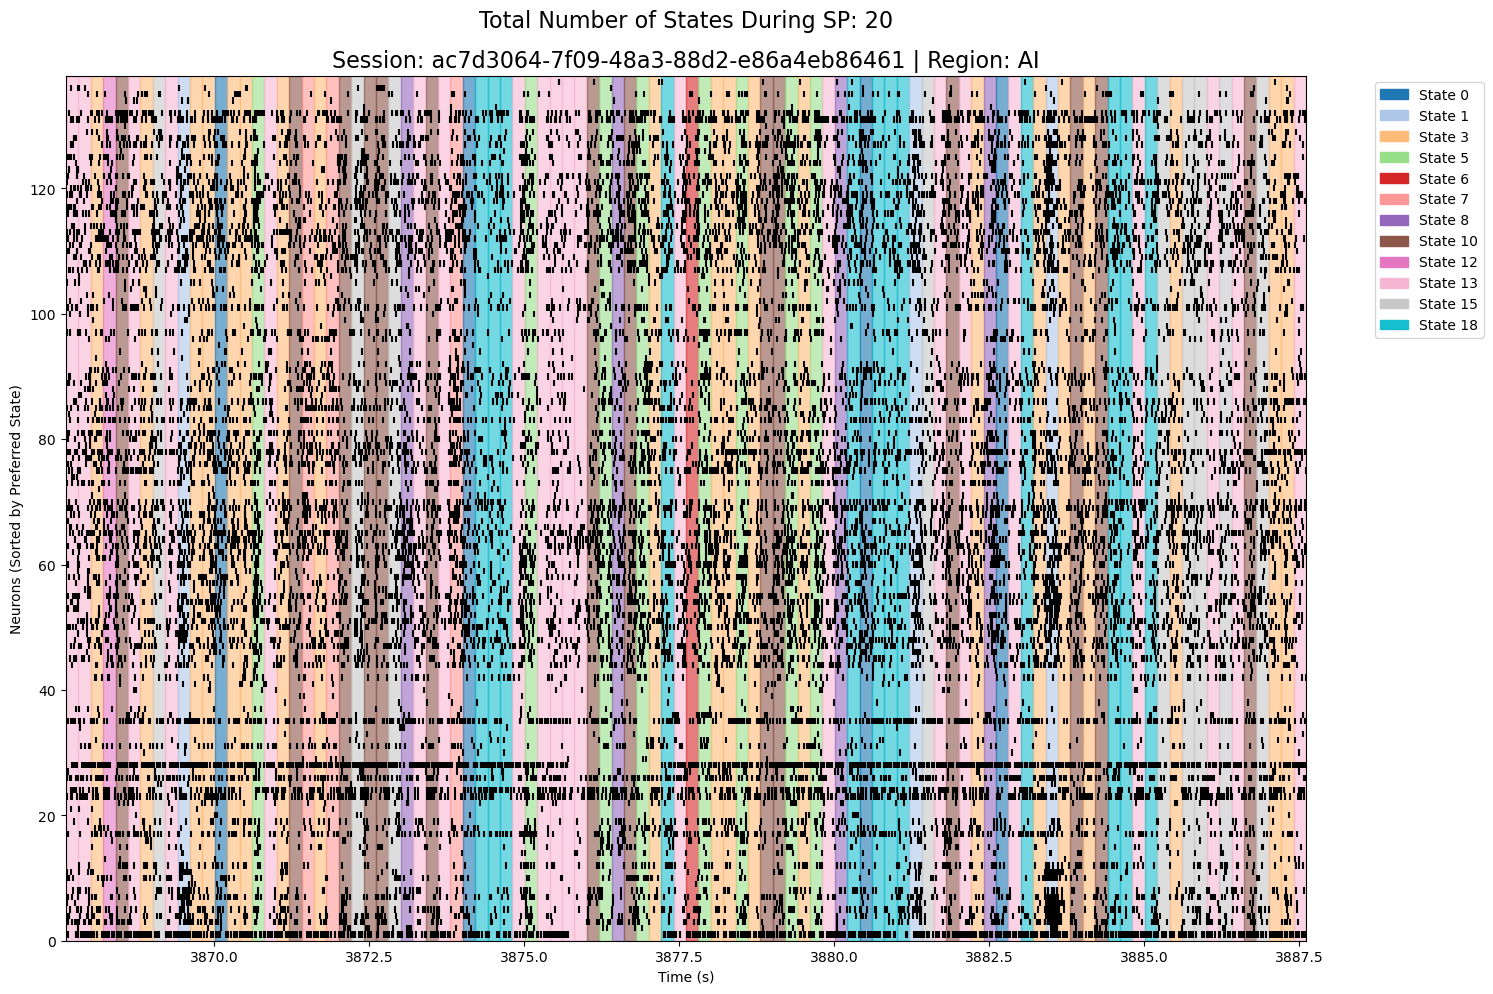

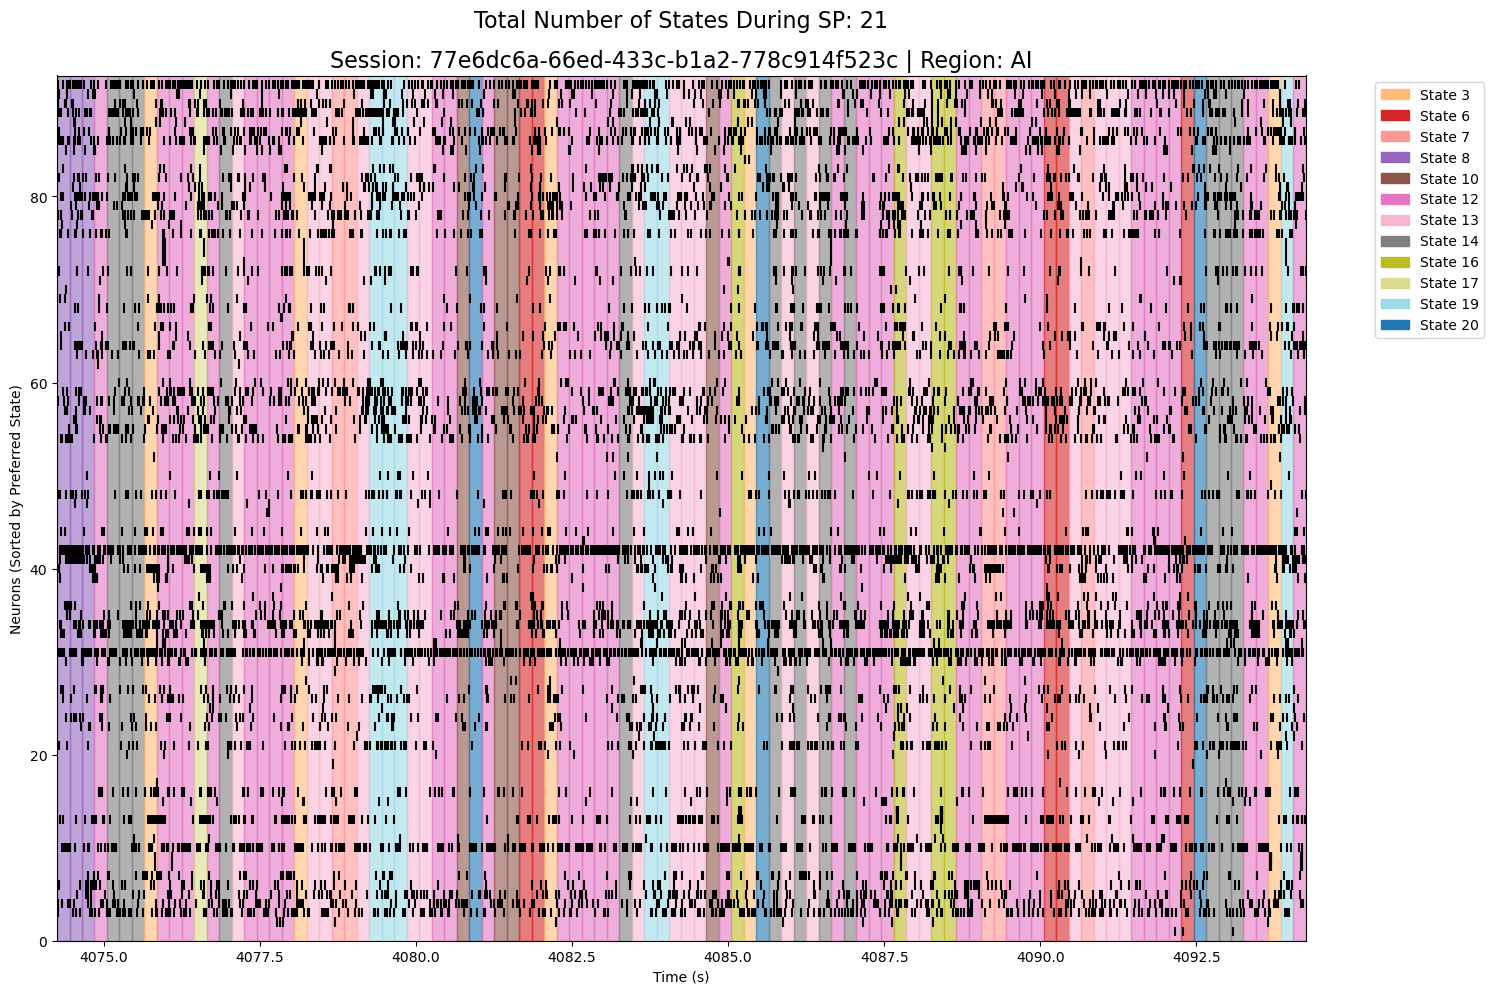

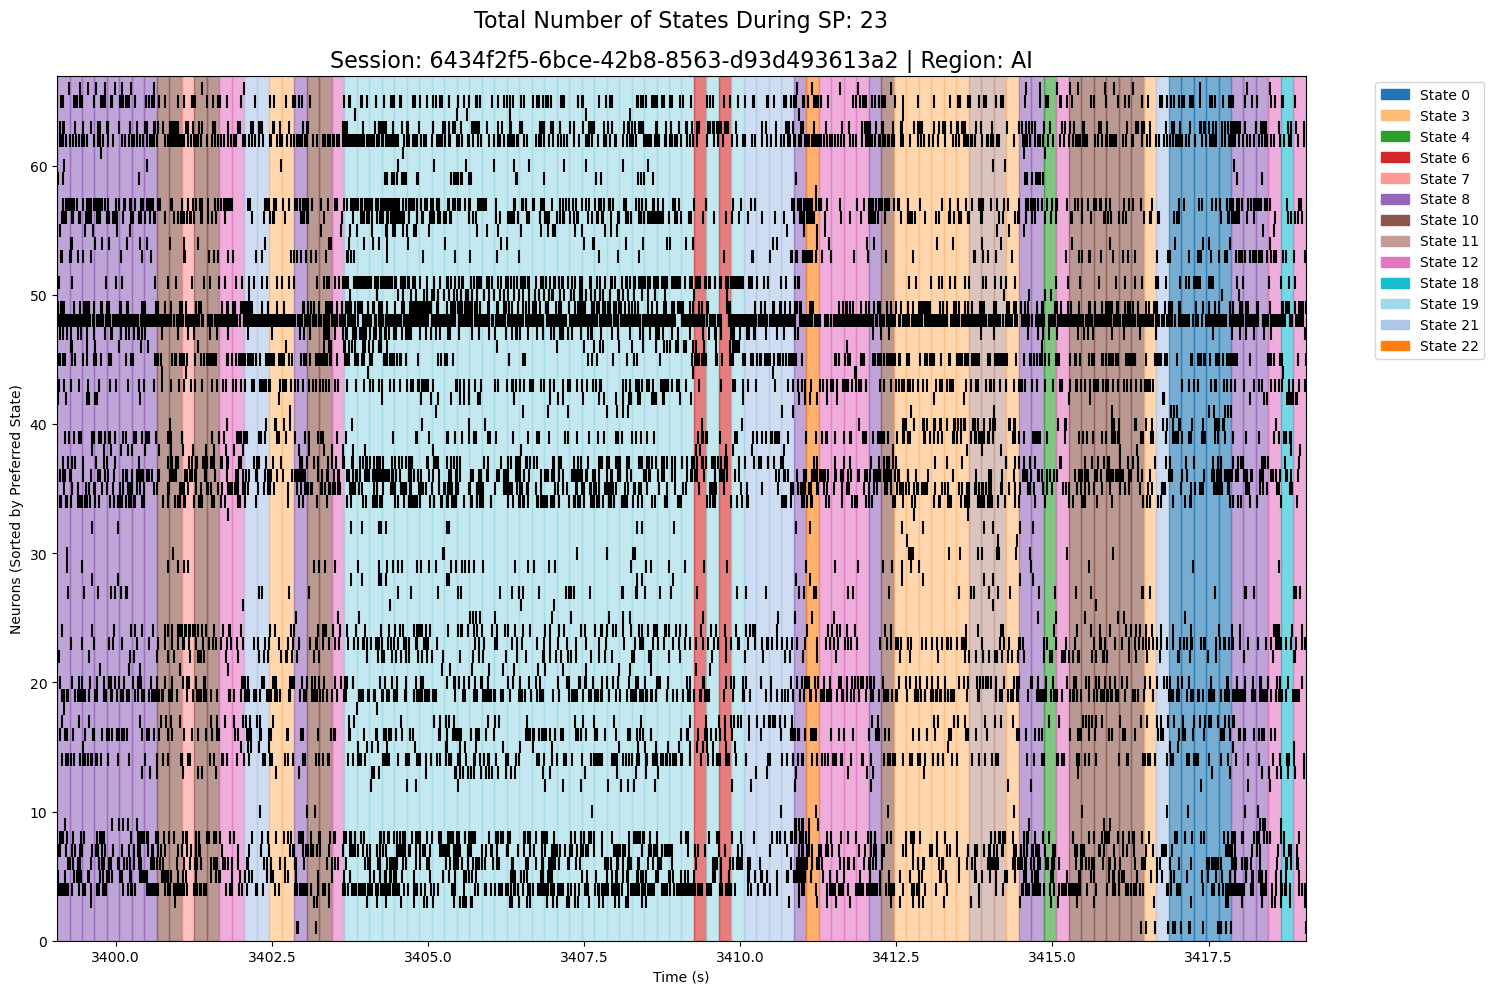

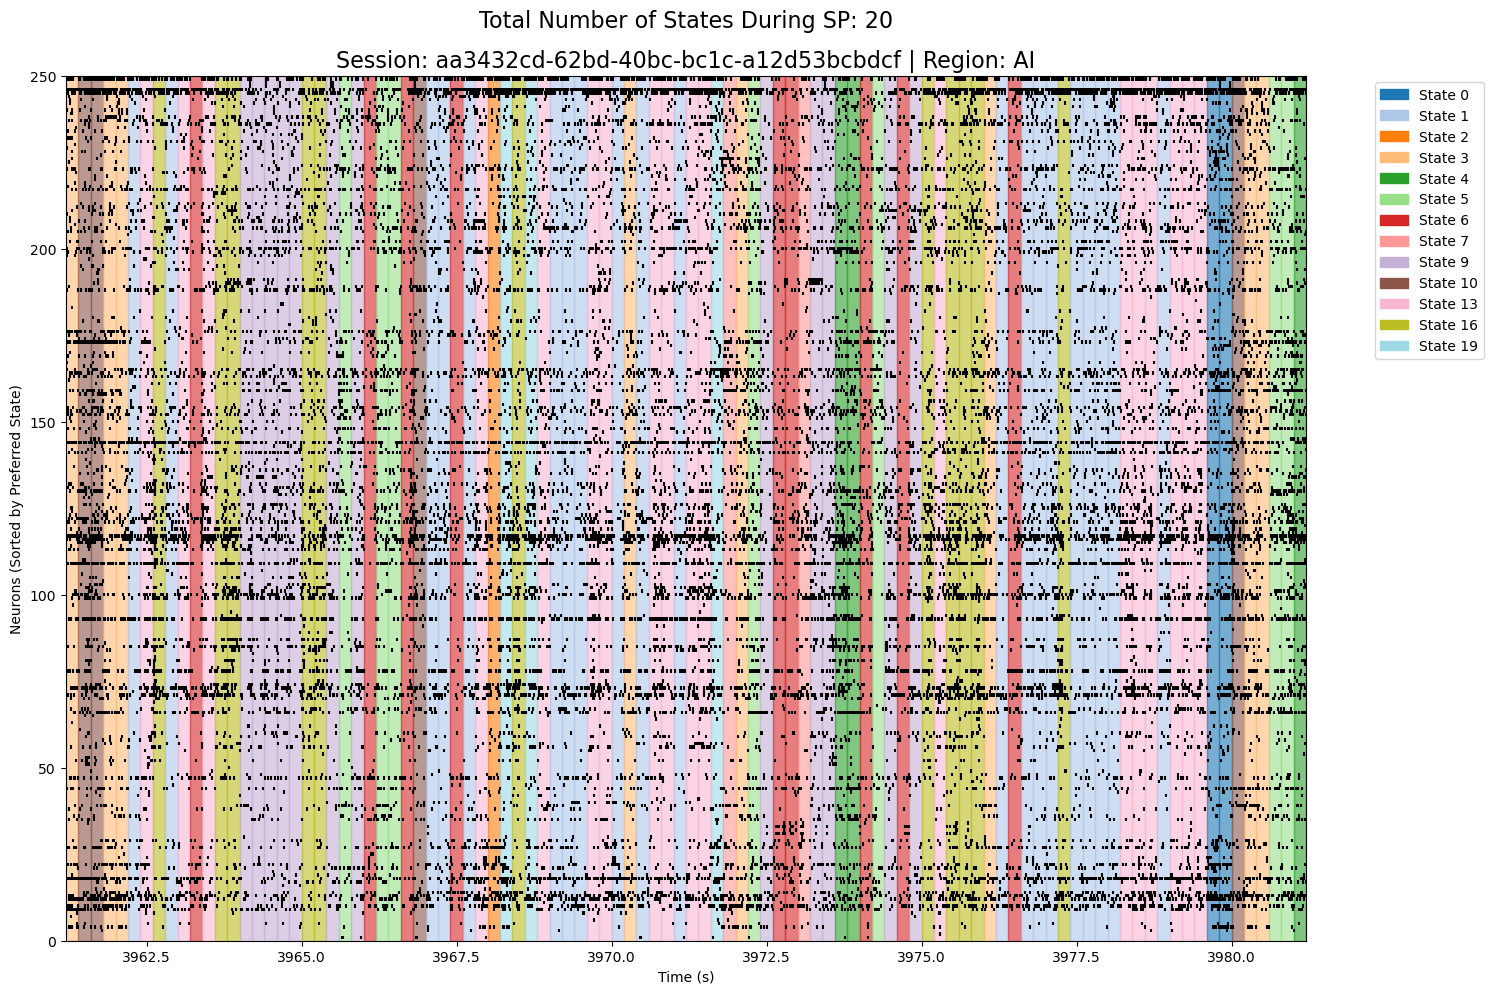

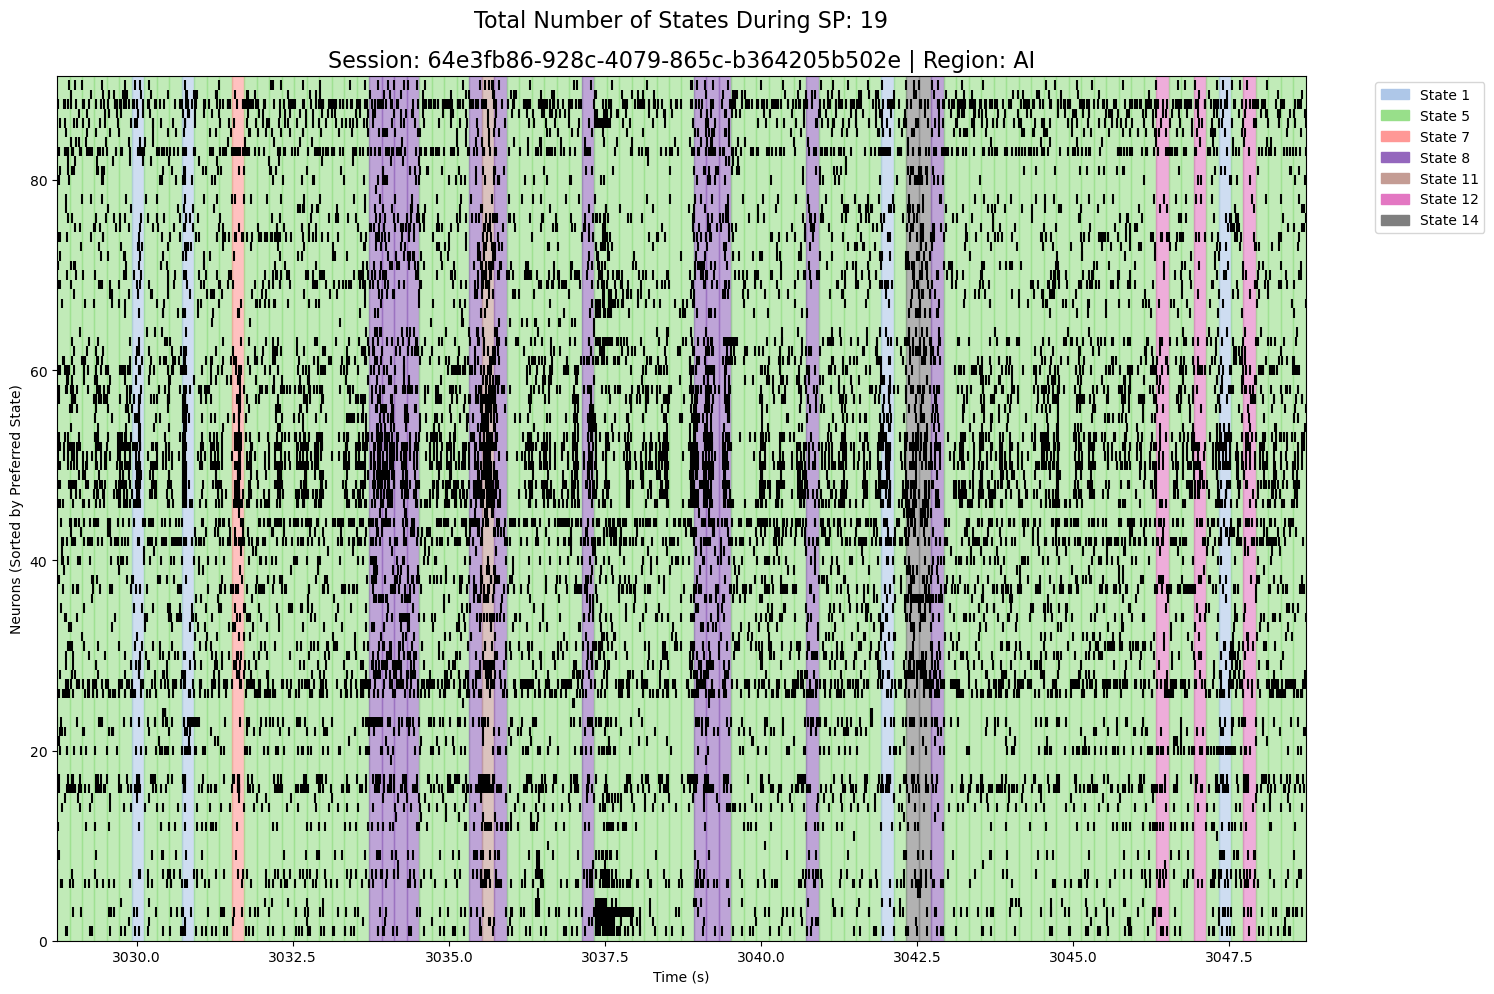

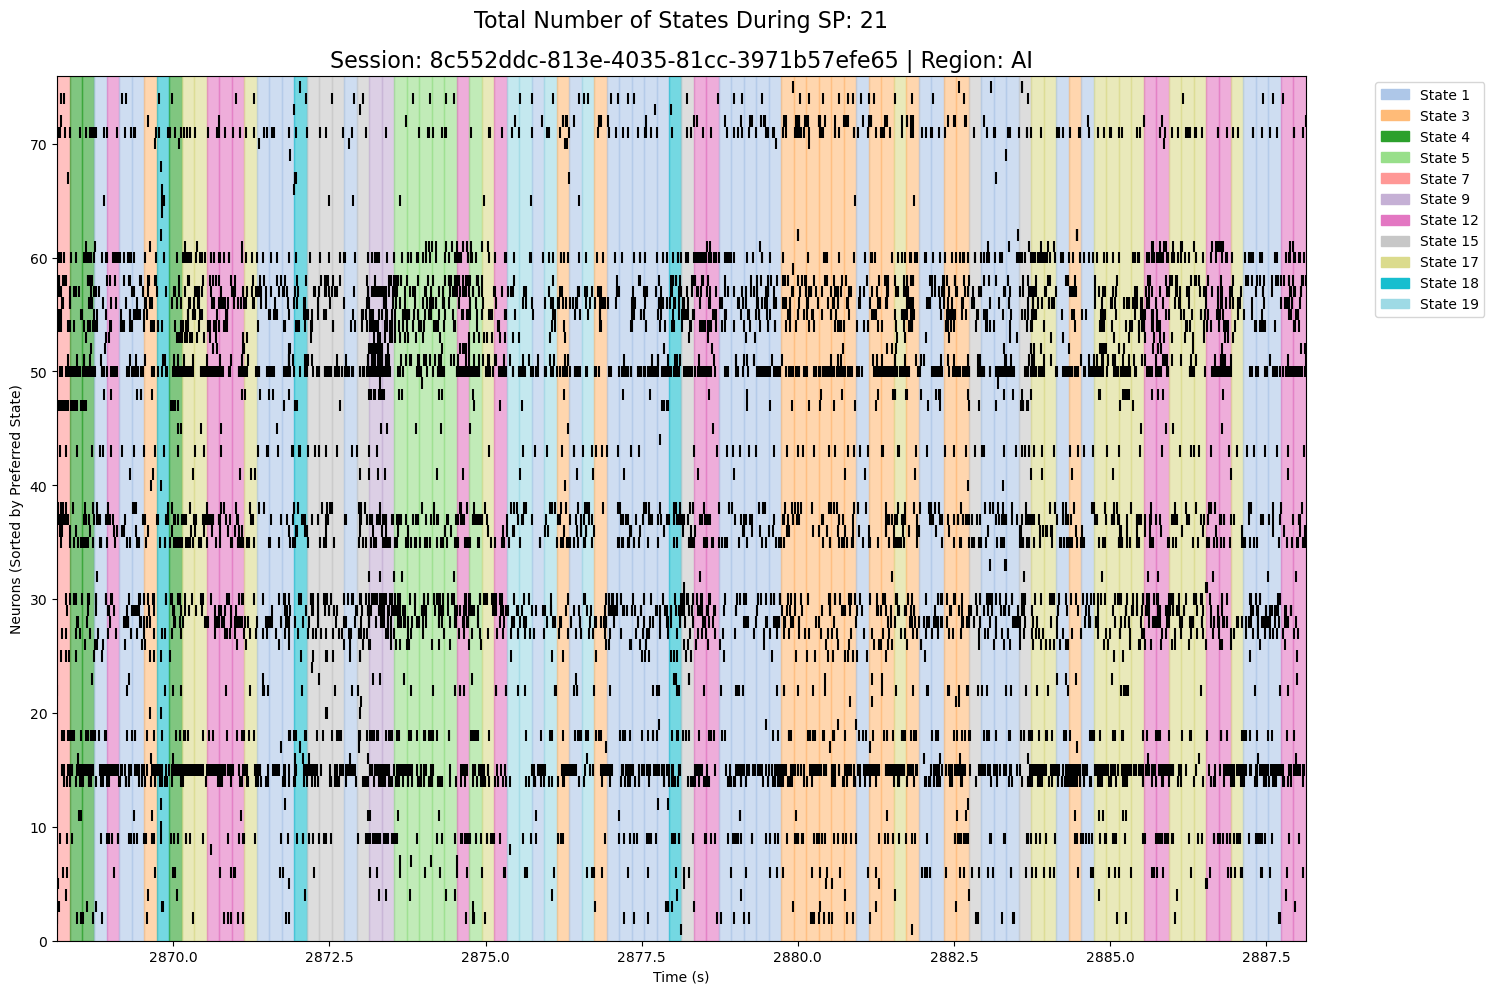

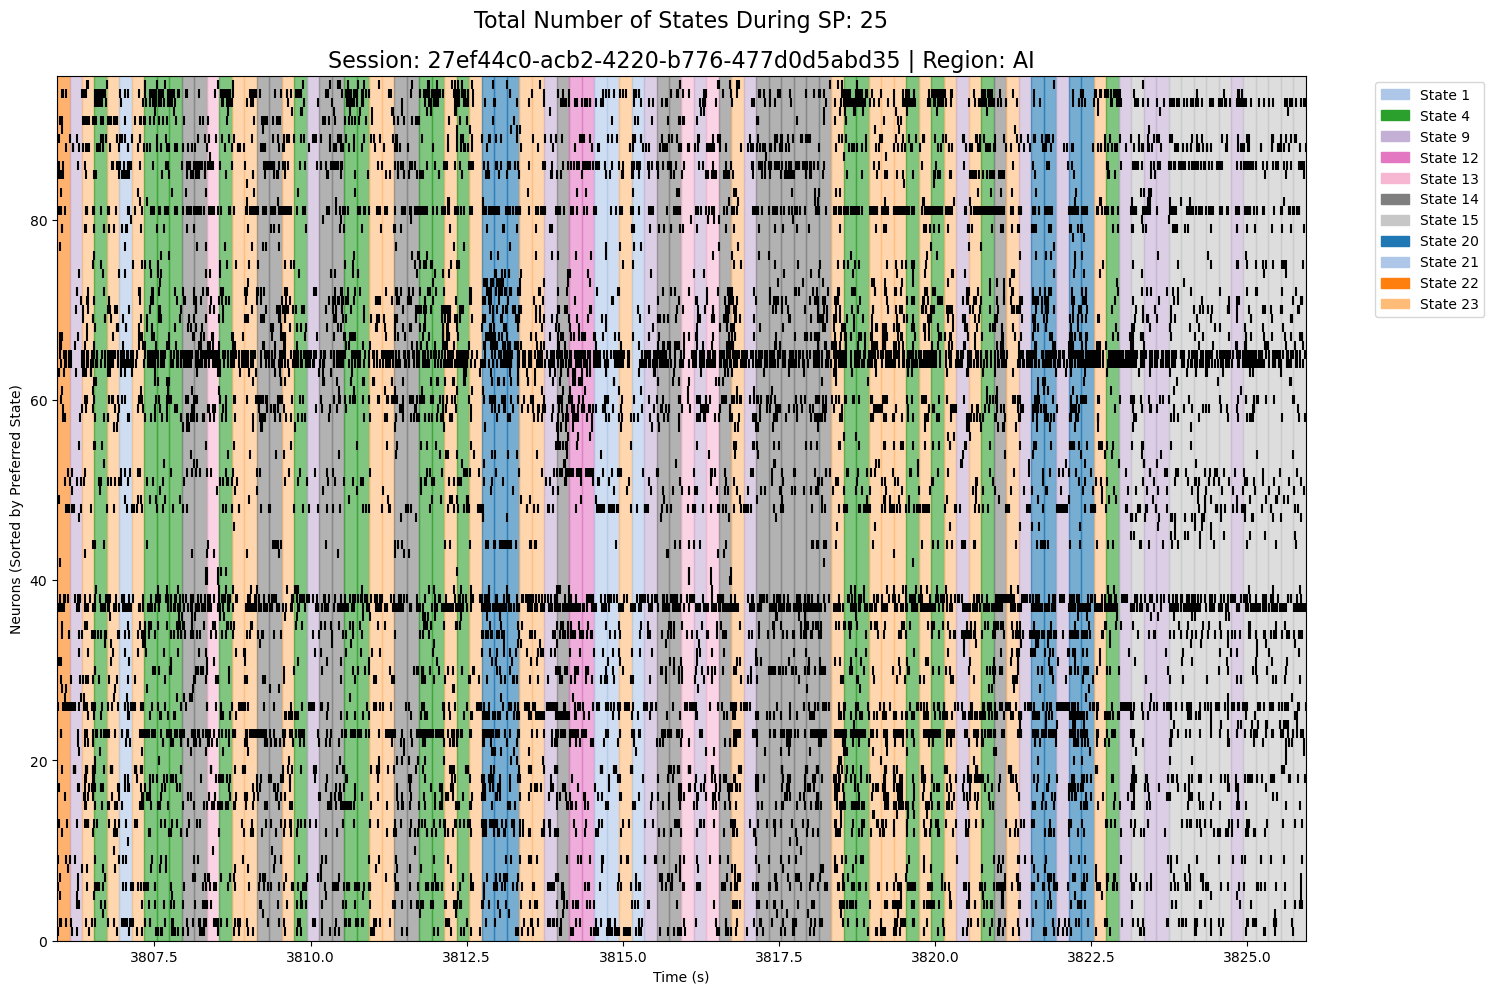

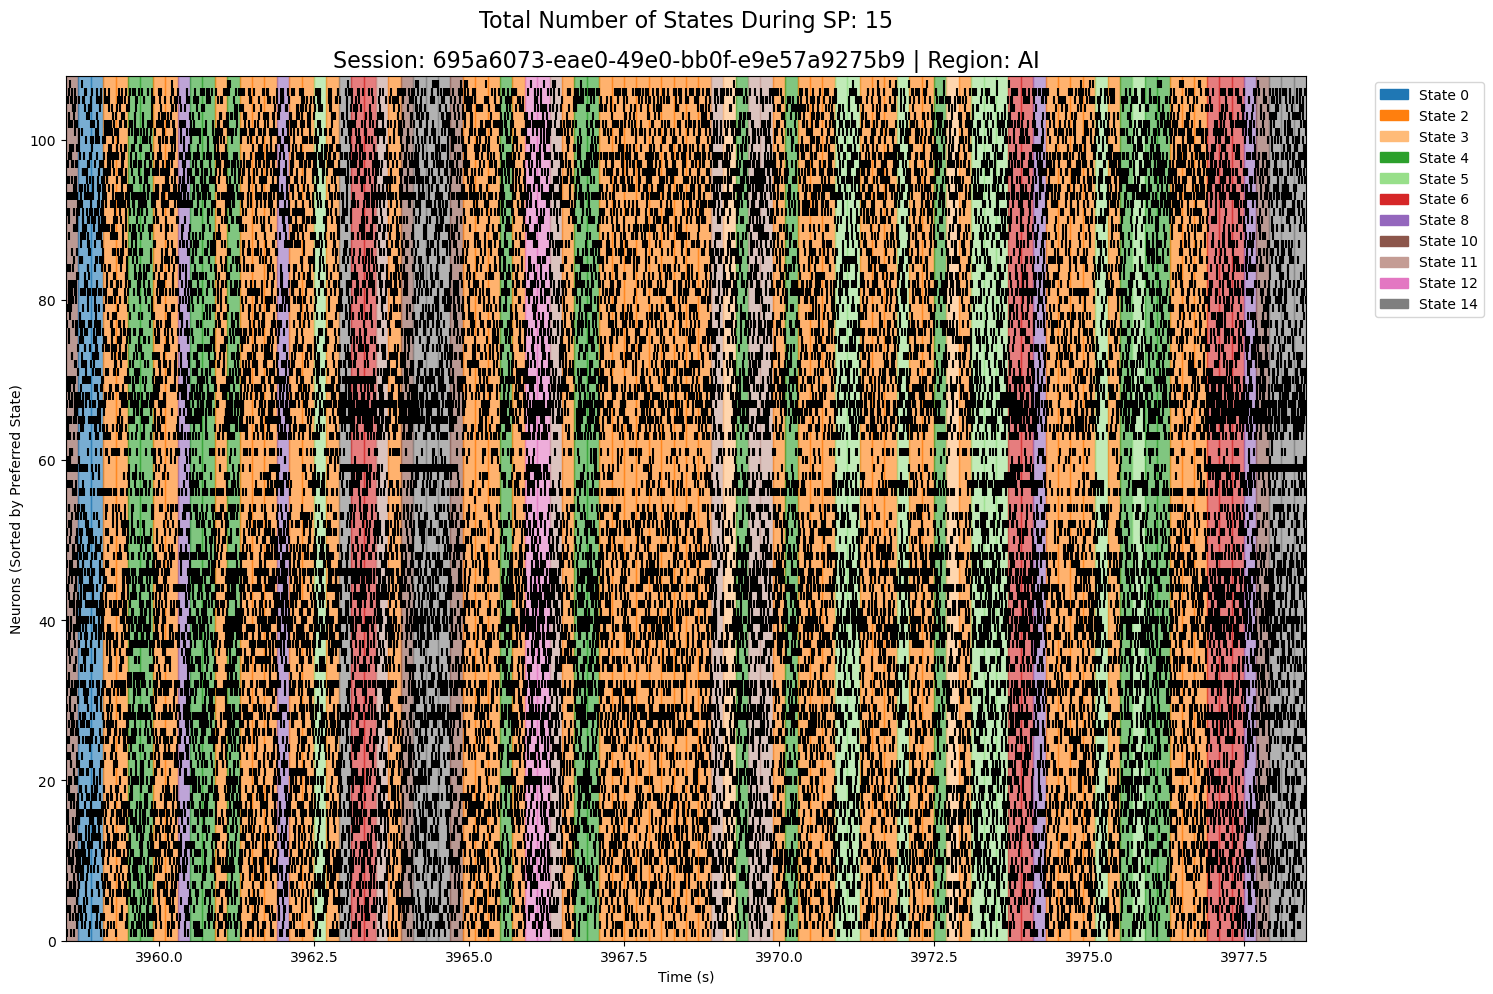

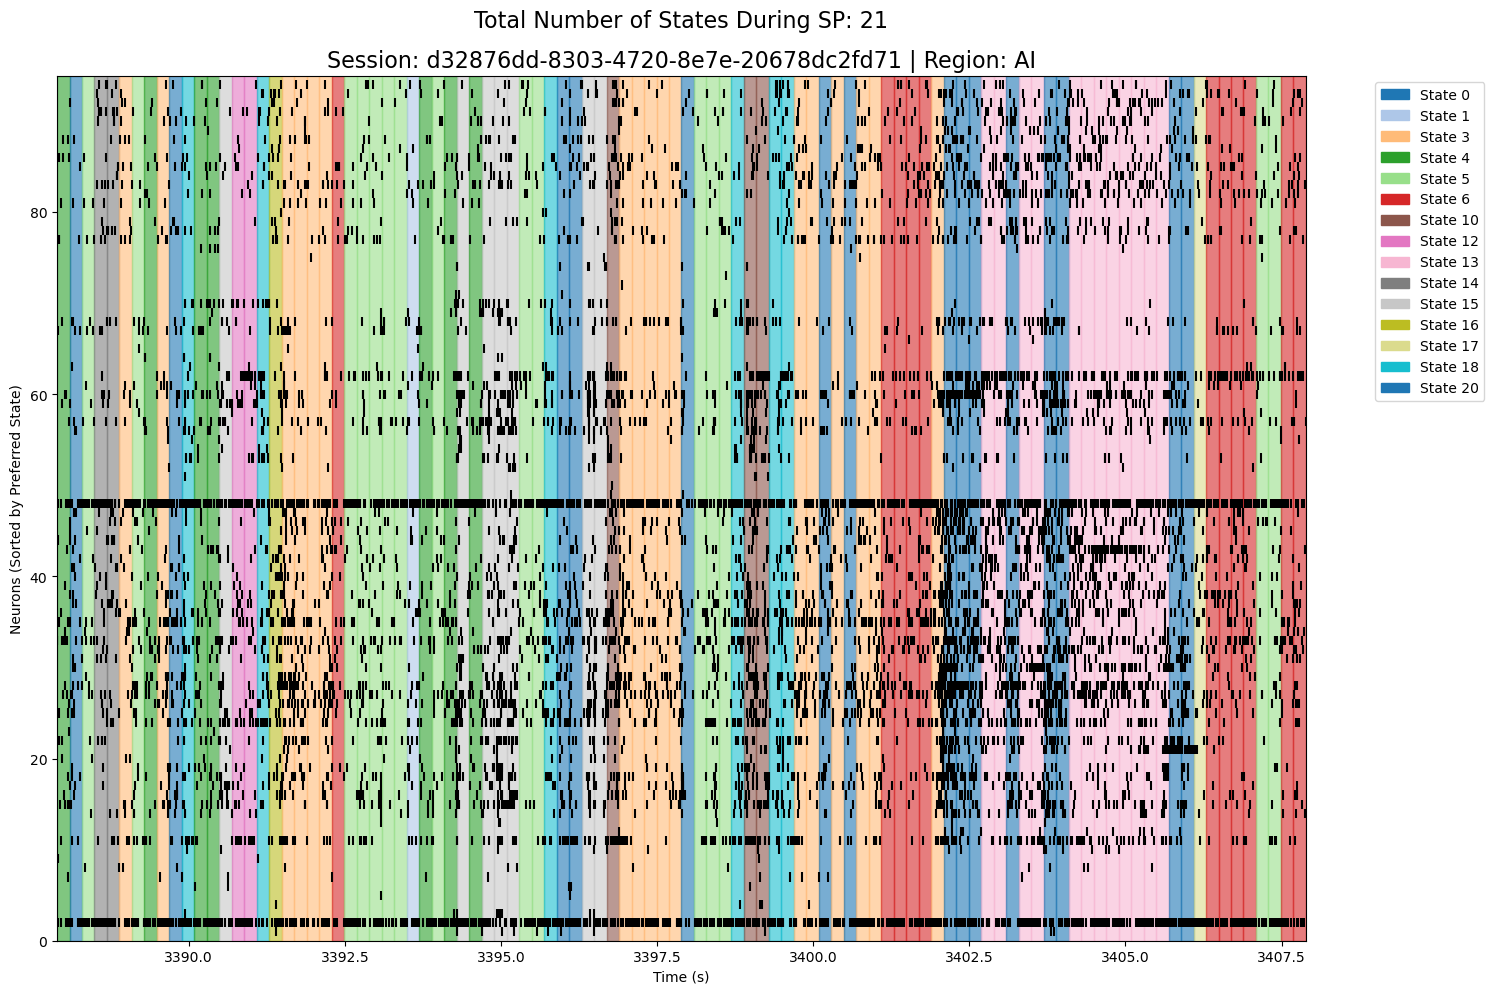

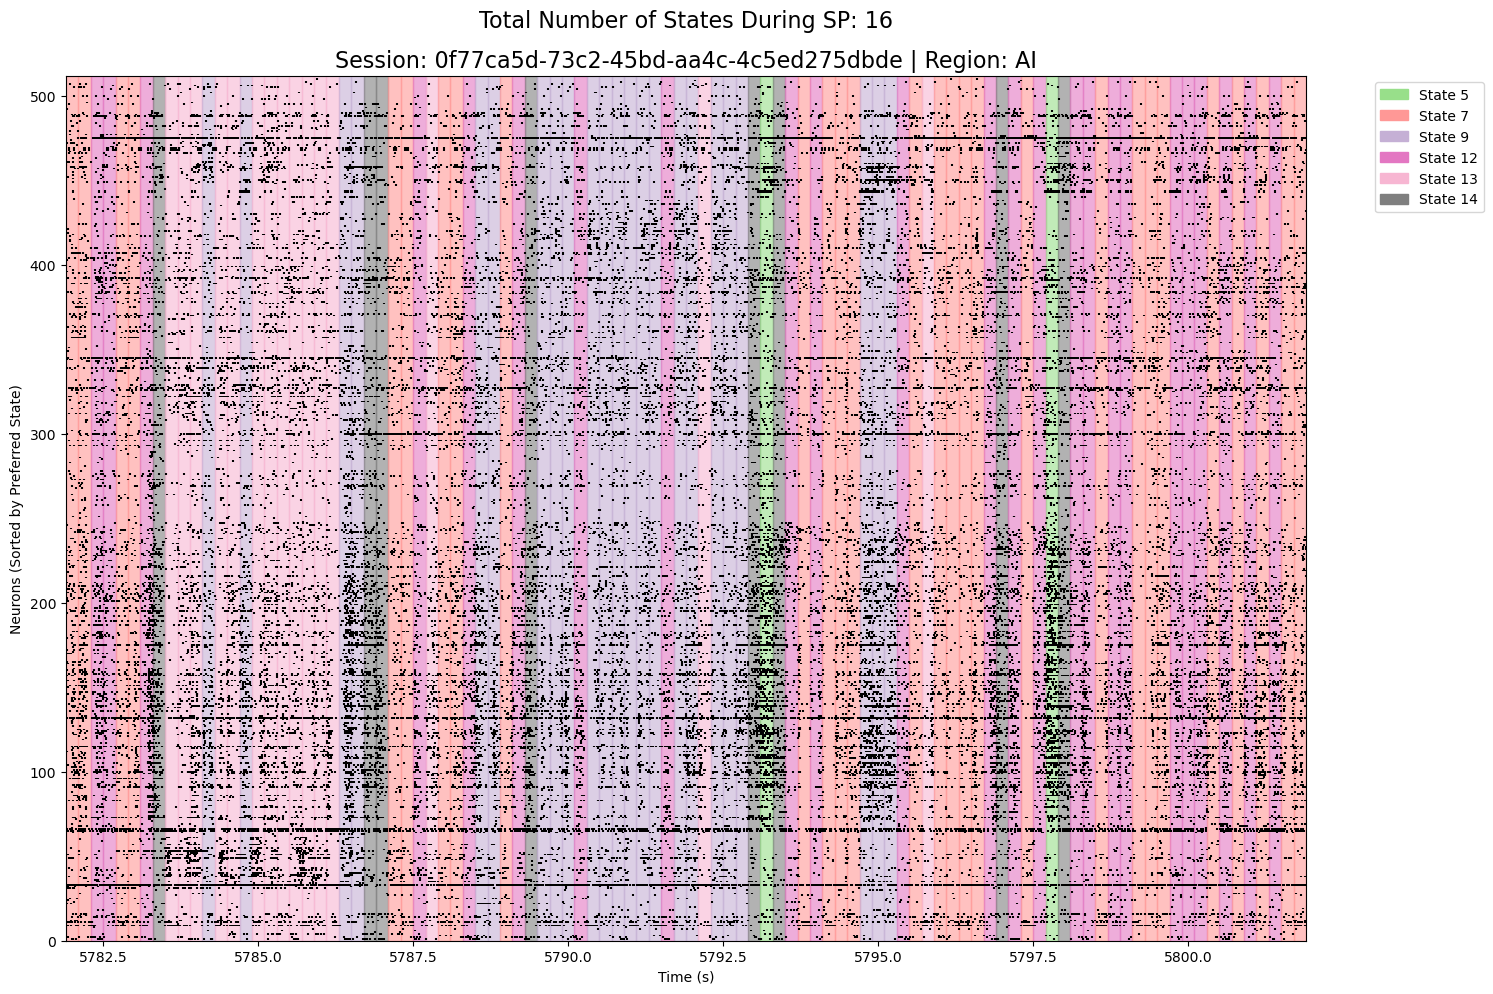

In [8]:
for session_id, regions in AI_ad.items():
    for region, data in regions.items():
        plot_sorted_raster_with_states(session_id, region, data)